# Data Analysis Project - Baseball Metrics

This analysis seeks to find a relationship, if any, between baseball player statistics to their salary. In the end, this analysis will attempt to determine a formula to predict salaries of baseball players. The questions this analysis seeks to analyze are: 
* What does the MLB salary growth look like in nominal dollars?
* How do salaries of All Stars compare to those who are not All Stars for the 2015 season?
* Are there more All Stars who attended college?

In [348]:
#import all relevant packages for this analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import division

from IPython.display import HTML

#This is done to hide the Python code
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [349]:
#import the salaries csv and fielding csv datasets

players = pd.read_csv("Master.csv")
salaries = pd.read_csv("Salaries.csv")
batting_stats = pd.read_csv("Batting.csv")
all_stars = pd.read_csv("AllstarFull.csv")
college = pd.read_csv("CollegePlaying.csv")

## Cleaning Up the Datasets

There are two salaries of "0" within the salaries table. These were removed from the dataset becasue it does not make sense for a player to have a salary of $0.

In [350]:
#remove salaries that are 0. These do not make sense.
salaries_cleaned = salaries[salaries["salary"] != 0]

#print out descriptive stats
salaries_cleaned["salary"].describe()

count    2.557300e+04
mean     2.008720e+06
std      3.315788e+06
min      1.090000e+04
25%      2.750000e+05
50%      5.500000e+05
75%      2.250000e+06
max      3.300000e+07
Name: salary, dtype: float64

Then we wanted to group the average salary by year. This is done for the analysis on salary growth.

In [351]:
#This was done to see how much the average MLB salary has moved in the past few years
salaries_by_year = salaries_cleaned.groupby("yearID", as_index = False).mean()

Now we want to look at salaries and All-Stars in the 2015 Season. To do this, we will subset the data using boolean indexing for each dataset. 

We use the notnull function and the count function to determine if there are the same number of rows listed in the dataset.

In [352]:
#take the salaries sheet and keep only 2015 salaries
salaries_15 = salaries_cleaned[salaries_cleaned["yearID"] == 2015]

all_stars_15 = all_stars[all_stars["yearID"] == 2015]
print all_stars_15["playerID"].notnull().sum() == all_stars_15["playerID"].count()

True


These functions look to count the number of players in each list to see if we are doing a 1:1 match. The first function "count_of_players" looks to count the number of players in a particular dataset. The second function "count_unique_players" looks to count the number of unique players in the dataset. 

This is done on only the All-Star players dataset and all others which are necessary. 

In [353]:
#count_of_players takes in a Pandas Series and returns the number of unique players in this particular series
def count_of_players(player_list, field_name):
    return player_list[field_name].count()

#count unique players takes a series that has already called unique on it
#this function just checks the prior function
def count_unique_players(player_list, field_name):
    player_list[field_name].nunique()
    return player_list[field_name].nunique()

In [354]:
#check if playerID is unique in this subset
print count_of_players(all_stars_15, "playerID") == count_unique_players(all_stars_15, "playerID")

True


We then create the "unique_players_with_salary" dataset to get a list of unique players in the dataset who have salaries listed in the 2015 season. After this, the following function: "count_unique_players" and "count_of_players"  are called to detemrine the number of players in the players with salaries merged dataset.

In [355]:
#check if unique salary counts match up with the original list
#salaries_15["playerID"].unique()
print count_unique_players(salaries_15, "playerID") == count_of_players(salaries_15, "playerID")

True


After getting our counts to be correct in the 2015 salaries dataset, I merged the unique list of All-Star players in the 2015 season to the 2015 salaries. In order to do a comparison of salaries for non All-Star players and All-Star players, the salaries_15 dataset values are kept. 

After this, a boolean column is generated on the basis of whether a gameID for the All-Star game is present. If a player does have a gameID, then that player will have True listed under the column "all_star". Otherwise, this will be false.

Use the boolean column, "all_star" to groupby to get the average salary of each group of players. The last line, that declares "clean_comparison" is used to only keep the all_star and salary columns to create a bar graph.

In [356]:
#merge the All Star list onto the Salaries List
all_player_salaries = all_stars_15.merge(salaries_15, on = "playerID", how = "right")

#the notnull function is used to add a column to the merged data set
#this will tell us if a player is an All Star or not
all_player_salaries["all_star"] = all_player_salaries["gameID"].notnull()

salary_comparison = all_player_salaries.groupby("all_star", as_index = False).mean()
clean_comparison = salary_comparison[["all_star","salary"]]

This next cell is used to sum the number of years a player attended a college. Considering that every player in this dataset attended a college, a 1 is assigned for that particular player and year.

After generating this column, the groupby function on the playerID is called and we sum all other fields. After this, only the playerID and number_of_years is kept.

In [357]:
#create a variable called count in the DataFrame
#this will be used to sum on in the groupby function in the player dataset
college["number_of_years"] = 1
grouped_college = college.groupby("playerID", as_index = False).sum()
college_years = grouped_college[["playerID","number_of_years"]]
college_years.head()

,playerID,number_of_years
0,aardsda01,3
1,abadan01,2
2,abbeybe01,4
3,abbotje01,3
4,abbotji01,3


First, we create a series with only the unique playerIDs that were All-Stars. We do this because it is possible to be an All-Star player multiple years. Then, we cast this as a dataframe to make the next merge easier.

The unique list of all stars is then merged onto the college years dataframe we constructed in the last cell. This allows us to create a column for whether someone attended college or not, which is based on the number_of_years column. 

Just for curiosity, check the number of players in the dataset. We will want to do some division later to get the percentage of players that attended college, so we created the count column equal to 1 for all observations.

In [367]:
all_all_stars_unique = all_stars["playerID"].unique()

unique_all_stars_df = pd.DataFrame(all_all_stars_unique, columns = ["playerID"])

all_stars_with_college = unique_all_stars_df.merge(college_years, on = "playerID", how = "left")
all_stars_with_college["college"] = all_stars_with_college["number_of_years"].notnull()

count_of_players(all_stars_with_college, "playerID")

all_stars_with_college["count"] = 1
all_stars_with_college.head()

,playerID,number_of_years,college,count
0,gomezle01,NaN,False,1
1,ferreri01,3.0,True,1
2,gehrilo01,1.0,True,1
3,gehrich01,NaN,False,1
4,dykesji01,NaN,False,1


## Salary Growth

([<matplotlib.axis.YTick at 0x122a614d0>,
 <a list of 5 Text yticklabel objects>)

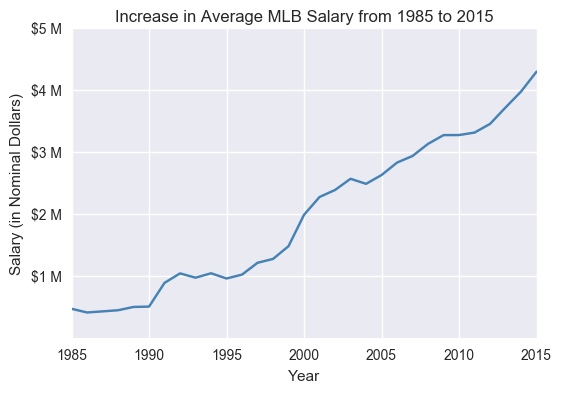

In [374]:
%matplotlib inline

# this graph displays a line graph showing how much the average salary has increase
# please note that this is the nominal wage and has not been adjusted for inflation
plt.plot(salaries_by_year["yearID"], salaries_by_year["salary"], color = "steelblue")
plt.xlabel("Year")
plt.ylabel("Salary (in Nominal Dollars)")
plt.title("Increase in Average MLB Salary from 1985 to 2015")
plt.yticks([1000000,2000000, 3000000, 4000000, 5000000],["$1 M","$2 M", "$3 M", "$4 M", "$5 M"] )

The chart shows the progression of the annual salary for MLB players from 1985 to 2015. Interestingly, within this chart, it is possible to see where new collective bargaining agreements might have happened. With more data, when there were new collective bargaining agreements or lock-outs, we would be able to determine how this affected average salaries in those years.

## Differences in All Stars vs. The Rest

In this section, we will seek to explain how much more an All Star made compared to an ordinary MLB player in the 2015 season.

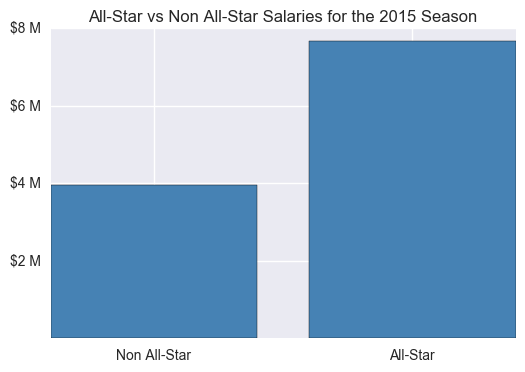

In [360]:
plt.bar(salary_comparison["all_star"], salary_comparison["salary"], color = "steelblue")
plt.xticks([0.4,1.4],["Non All-Star", "All-Star"])
plt.yticks([2000000,4000000,6000000,8000000],["$2 M","$4 M","$6 M","$8 M"])
plt.title("All-Star vs Non All-Star Salaries for the 2015 Season")

The average All-Star in the 2015 season made twice as much as the non All-Star player. Needless to say, this is not an alarming result as All-Star players must have some attribute about them that deserves a higher salary.

## Going to College
This next analysis seeks to understand the difference in college-going rates for All-Star players versus non All-Star players. While this analysis is rather elementary, we do want to see if going to college matters to become an All-Star player. We also examine how many years a player played in college to see if there is a relationship between years played in college and being an All-Star.

In [369]:
college_goers = all_stars_with_college["college"].sum()
total = all_stars_with_college["count"].sum()

percent_of_all_stars_college = college_goers / total
print "{0:.0f}%".format(percent_of_all_stars_college * 100)

36%


From this data, we can see that about 36 percent of All-Star MLB players attended a college. Please keep in mind this does not mean 64 percent of the All-Stars did not go to a post-secondary institution. There are scenarios in which players come from another country and a junior college not listed in the college dataset.

One thing that I wanted to know when doing this analysis was how long an All-Star attended a college, if they went to one at all.

In [373]:
print all_stars_college_only["number_of_years"].mean()

2.52614896989


From exploring the number of years attended, we can see that the average All-Star, who attended a college, attended for about 2.5 years. 

## Conclusion

None of these findings are final and do need to be investigated further. However, the initial findings show interesting behavior about salaries, how salaries compare among All-Star and non All-Star MLB players and even differences in college going. To conclude these results more final, it would be useful to check if they are statistically different from the mean. These particular analyses are quite limited. While we have explored the changes in salary. These are not adjusted for inflation to see the real differences in wages. 

The analysis of All-Star MLB players is limited in its scope to just looking at salary differences and whether someone went to college. In further analysis, it will be useful to determine what particular statistics by position create these differences. This could also be used to explain difference in salaries. In the future, I would like to conduct regression analysis based on individual position statistics to determine salaries. 

This analysis has been a really good first introduction into how to use Pandas and NumPy to analyze data in Python. Thank you Udacity.